In [1]:
# Import needed libraries 

import pandas as pd 
import os
import datetime
from datetime import timedelta
import numpy as np 
from scipy.signal import argrelextrema
import alpaca_trade_api as tradeapi 
import matplotlib.pyplot as plt 
import matplotlib.dates as mpdates
from mplfinance.original_flavor import candlestick_ohlc
from dotenv import load_dotenv
from itertools import islice
from pandas .tseries.offsets import DateOffset

# Ignore any non-critical future warnings

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:

# Load .env file

load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
ALPACA_ENDPOINT_KEY = os.getenv("ALPACA_END_POINT")


# Create the Alpaca API object
api = tradeapi.REST(
    ALPACA_API_KEY,
    ALPACA_SECRET_KEY,
    api_version="v2",
    base_url= ALPACA_ENDPOINT_KEY
)

In [4]:
# Parameters for Stock Data from Alpacas
# Establish time frame (5 minute)

time_frame = "5min"

# Identify what stock symbol is trading

stock_symbol = "QQQ"

# Identify what start date to begin data analysis

start_date = pd.Timestamp("2020-01-01", tz="America/New_York").isoformat()

# Identify what end date to finalize data analysis

end_date = pd.Timestamp("2022-01-01", tz="America/New_York").isoformat()

In [5]:
# Function to call daily stock data

def get_stock_data(api, stock_symbol, time_frame, start_date, end_date):
    
    # Assuming api.get_bars returns a DataFrame with a 'df' attribute
    
    stock_data = api.get_bars(
        stock_symbol, 
        time_frame, 
        start=start_date, 
        end=end_date
        ).df
    return stock_data

stock_data = get_stock_data(api, stock_symbol, time_frame, start_date, end_date)

# Displays the information pulled for working through code

stock_data.info()
display(stock_data.head())
display(stock_data.tail())

sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/QQQ/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/QQQ/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/QQQ/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/QQQ/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/QQQ/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/QQQ/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/QQQ/bars 3 more time(s)...
sleep 3 seconds and retrying https://data.alpaca.markets/v2/stocks/QQQ/bars 3 more time(s)...


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93409 entries, 2020-01-02 09:00:00+00:00 to 2021-12-31 22:45:00+00:00
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        93409 non-null  float64
 1   high         93409 non-null  float64
 2   low          93409 non-null  float64
 3   trade_count  93409 non-null  int64  
 4   open         93409 non-null  float64
 5   volume       93409 non-null  int64  
 6   vwap         93409 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 5.7 MB


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2020-01-02 09:00:00+00:00,214.06,214.06,213.95,35,213.98,16478,214.001984
2020-01-02 09:05:00+00:00,214.13,214.18,214.03,13,214.03,2563,214.148354
2020-01-02 09:10:00+00:00,214.18,214.18,214.13,15,214.13,1666,214.145222
2020-01-02 09:15:00+00:00,214.20,214.20,214.14,26,214.18,18592,214.173761
2020-01-02 09:20:00+00:00,214.18,214.18,214.15,5,214.17,1600,214.173750


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-12-31 22:05:00+00:00,397.82,397.8200,397.70,15,397.70,1488,397.799281
2021-12-31 22:10:00+00:00,397.88,397.8800,397.82,28,397.82,2019,397.840766
2021-12-31 22:15:00+00:00,397.88,397.8800,397.87,12,397.88,589,397.874923
2021-12-31 22:25:00+00:00,397.85,397.9010,397.85,33,397.85,4154,397.870848
2021-12-31 22:45:00+00:00,397.85,397.8501,397.85,14,397.85,437,397.853044


In [6]:
# Function to prepare daily stock data to identify double top/bottom patterns and prepare for targets
# Includes establishing a polynomial fit and assigning new columns for localized min/max

# Polynomial Degree

polynomial_degree = 25

def polynomial_min_max_fit(stock_data, polynomial_degree):
    
    min_length = len(stock_data.index)
    x_data = np.arange(min_length)

    # Polynomial fitting
    polynomial_coefficients_open = np.polyfit(x_data, stock_data['open'][:min_length], polynomial_degree)
    polynomial_coefficients_high = np.polyfit(x_data, stock_data['high'][:min_length], polynomial_degree)
    polynomial_coefficients_low = np.polyfit(x_data, stock_data['low'][:min_length], polynomial_degree)
    polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)

    # Evaluate the polynomial fit for plotting
    y_polynomial_open = np.polyval(polynomial_coefficients_open, x_data)
    y_polynomial_high = np.polyval(polynomial_coefficients_high, x_data)
    y_polynomial_low = np.polyval(polynomial_coefficients_low, x_data)
    y_polynomial_close = np.polyval(polynomial_coefficients_close, x_data)

    # Identify local extrema for polynomial fit data (minima and maxima)
    local_poly_minima = argrelextrema(y_polynomial_close, np.less, order=5)[0]
    local_poly_maxima = argrelextrema(y_polynomial_close, np.greater, order=5)[0]

    # Convert the close price polynomial fit data into a dataframe
    # This is done for OHLC poly fit data

    poly_df = pd.DataFrame(y_polynomial_open)
    columns = ['poly_fit_open']
    poly_df.columns = columns
    poly_df = poly_df.assign(poly_fit_high = y_polynomial_high)
    poly_df = poly_df.assign(poly_fit_low = y_polynomial_low)
    poly_df = poly_df.assign(poly_fit_close = y_polynomial_close)

    # Reset the index of the original updated ticker dataframe to concat with the polynomial dataframe that does not include a timeseries
    # This will ensure that the indexed intergers of the ploynomial fit align with the time each data point corresponds to

    updated_stock_data = stock_data.reset_index()
    updated_stock_data = pd.concat([updated_stock_data, poly_df], axis='columns', join='inner')
    updated_stock_data.head()

    # Add minima and maxima column to the DataFrame

    updated_stock_data["minima"] = 0
    updated_stock_data["maxima"] = 0
    updated_stock_data.head()

    # Mark rows with local minima as 1 in the 'minima' column

    for index in local_poly_minima:
        updated_stock_data.at[index, 'minima'] = -1

    for index in local_poly_maxima:
        updated_stock_data.at[index, "maxima"] = 1

    # Create Target Columns - Double Top Target & Double Bottom Target
        
    updated_stock_data["dbl_top_target"] = 0
    updated_stock_data["dbl_bot_target"] = 0

   
    return updated_stock_data

# For data checking/confirmation
updated_stock_data = polynomial_min_max_fit(stock_data,polynomial_degree)
updated_stock_data.head()

C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_15100\2575141905.py:14: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_open = np.polyfit(x_data, stock_data['open'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_15100\2575141905.py:15: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_high = np.polyfit(x_data, stock_data['high'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_15100\2575141905.py:16: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_low = np.polyfit(x_data, stock_data['low'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_15100\2575141905.py:17: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)


,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,2020-01-02 09:00:00+00:00,214.06,214.06,213.95,35,213.98,16478,214.001984,222.312897,222.434759,222.197633,222.319908,0,0,0,0
1,2020-01-02 09:05:00+00:00,214.13,214.18,214.03,13,214.03,2563,214.148354,222.286492,222.408292,222.171272,222.293503,0,0,0,0
2,2020-01-02 09:10:00+00:00,214.18,214.18,214.13,15,214.13,1666,214.145222,222.260134,222.381871,222.144957,222.267145,0,0,0,0
3,2020-01-02 09:15:00+00:00,214.20,214.20,214.14,26,214.18,18592,214.173761,222.233822,222.355496,222.118689,222.240832,0,0,0,0
4,2020-01-02 09:20:00+00:00,214.18,214.18,214.15,5,214.17,1600,214.173750,222.207556,222.329168,222.092468,222.214567,0,0,0,0


C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_15100\2995550416.py:11: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)


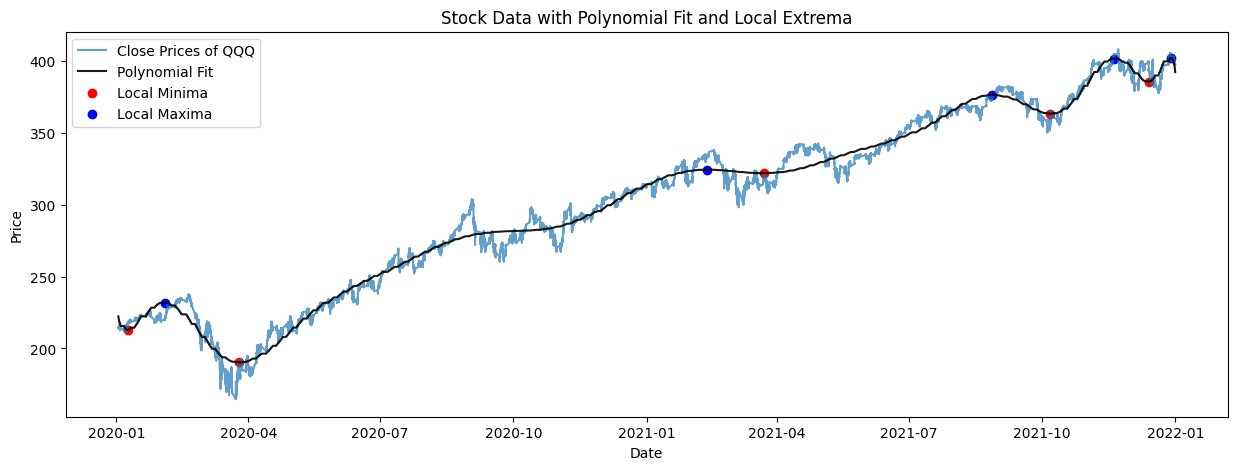

In [7]:
# Plot data
# Plot the stock data and identified minima

plt.figure(figsize=(15, 5))
plt.plot(stock_data.index, stock_data["close"], label='Close Prices of QQQ', alpha=0.7)

# # Plot polynomial fit

min_length = len(stock_data.index)
x_data = np.arange(min_length)
polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)
y_polynomial_close = np.polyval(polynomial_coefficients_close, x_data)
local_poly_minima = argrelextrema(y_polynomial_close, np.less, order=5)[0]
local_poly_maxima = argrelextrema(y_polynomial_close, np.greater, order=5)[0]


plt.plot(stock_data.index[:min_length], y_polynomial_close, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# # Plot red dots at local minima and blue dots at local maxima

plt.scatter(stock_data.index[local_poly_minima], y_polynomial_close[local_poly_minima], color='red', label='Local Minima')
plt.scatter(stock_data.index[local_poly_maxima],y_polynomial_close[local_poly_maxima], color="blue", label = "Local Maxima")

# Add titles and labels
plt.title('Stock Data with Polynomial Fit and Local Extrema')
plt.xlabel('Date')
plt.ylabel('Price')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [8]:
# Define the time independent DF for double top/bottom identification
# Timestamp remains a column, but can identify pattern from peak to peak immediately

def time_independent_data(updated_stock_data):

    # Define and establish time independent DF

    time_independent_df = []
    time_independent_df = pd.DataFrame(time_independent_df, columns = ["timestamp","close","high","low","trade_count","open","volume","vwap","poly_fit_open","poly_fit_high","poly_fit_low","poly_fit_close","minima","maxima", "dbl_top_target","dbl_bot_target"])

    # Loop to iterate through all rows of stock data and write min/max to new DF

    for index, row in islice(updated_stock_data.iterrows(), 0, None):

        # Assign to rows only those that contain local min or max

        if (updated_stock_data.at[index,"minima"] == -1):
            time_independent_df.loc[index] = row
            a = updated_stock_data.iloc[index]["poly_fit_close"]
        elif (updated_stock_data.at[index,"maxima"] == 1):
            time_independent_df.loc[index] = row
            a = updated_stock_data.iloc[index]["poly_fit_close"]

    # Reset time dependent index
    # Set new time independent index

    time_independent_df.reset_index(inplace = True)
    time_independent_df.rename(columns={"index":"time_dependent_index"}, inplace = True)

    return time_independent_df

# Data confirmation/check

time_independent_df = time_independent_data(updated_stock_data)
time_independent_df.head(10)

,time_dependent_index,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,poly_fit_low,poly_fit_close,minima,maxima,dbl_top_target,dbl_bot_target
0,830,2020-01-08 17:35:00+00:00,217.18,217.31,217.0809,1183,217.31,174826,217.191854,212.906729,212.975557,212.834273,212.912357,-1,0,0,0
1,3933,2020-02-03 19:25:00+00:00,222.075,222.19,222.02,646,222.11,85620,222.09234,231.93958,232.02857,231.845371,231.935618,0,1,0,0
2,10652,2020-03-25 20:45:00+00:00,182.21,182.3,181.97,74,182.07,20308,182.112654,190.29587,190.650903,189.938768,190.296639,-1,0,0,0
3,51863,2021-02-11 11:40:00+00:00,334.08,334.2,334.08,13,334.2,1433,334.156678,324.488517,324.670209,324.298436,324.485747,0,1,0,0
4,56792,2021-03-22 18:45:00+00:00,320.2389,320.48,320.23,2117,320.355,760610,315.812195,322.06947,322.288149,321.8419,322.067058,-1,0,0,0
5,77214,2021-08-27 10:55:00+00:00,373.69,373.76,373.69,23,373.76,1478,373.717341,376.548024,376.648634,376.446739,376.546262,0,1,0,0
6,82283,2021-10-06 20:35:00+00:00,360.02,360.04,359.98,113,360.02,25972,360.007685,363.575218,363.753714,363.392343,363.573727,-1,0,0,0
7,88091,2021-11-19 09:25:00+00:00,403.67,403.96,403.67,83,403.96,10357,403.79823,401.913627,402.068021,401.758588,401.911189,0,1,0,0
8,91007,2021-12-13 23:10:00+00:00,392.5,392.56,392.5,22,392.56,3701,392.523883,385.931744,386.211154,385.640498,385.925431,-1,0,0,0
9,92891,2021-12-29 09:00:00+00:00,403.26,403.31,402.89,101,402.89,6532,403.027337,402.401855,402.505559,402.289965,402.407564,0,1,0,0


In [9]:
# Function to identify daily double top/bottom patterns
# Inherently there should only be 1 identification of the pattern as it is considered a trend reversal pattern
# The loop will break once the pattern is identified

def identify_double_patterns(time_independent_df, updated_stock_data):

    # Initialize variables to identify double top/bottom patterns
    # Time dependent variable x_0 will always begin at a local min/max which also coincides
    # With the start of a trend into a potential double top/bottom
    
    x_0 = 0

    # Initiation of double top/bottom variable
    
    a = 0

    # First peak/valley of double top/bottom pattern
    
    b = 0

    # Trough/peak of double top/bottom pattern

    c = 0

    # Second peak/vallye of double top/bottom pattern
    
    d = 0

    # Trigger of double top/bottom pattern
    
    e = 0

    # Final time increment to finalize and trigger double top signal
    
    x_f = 0

    # Read through code to identify double top/bottom and assign to target columns.

    for index, row in islice(time_independent_df.iterrows(), 0, len(time_independent_df) - 4):

        # Check for double top
        # If found then assigns x_f final time for writing to targets in time dependent dataframe

        if (time_independent_df.at[index,"minima"] == -1):
            a = time_independent_df.iloc[index]["poly_fit_close"]
            b = time_independent_df.iloc[index + 1]["poly_fit_close"]
            c = time_independent_df.iloc[index + 2]["poly_fit_close"]
            d = time_independent_df.iloc[index + 3]["poly_fit_close"]
            e = time_independent_df.iloc[index + 4]["poly_fit_close"]
            x_0 = time_independent_df.iloc[index]["time_dependent_index"]

            if (time_independent_df.iloc[index + 1]["poly_fit_low"])*.95 < d < (time_independent_df.iloc[index + 1]["poly_fit_high"])*1.05 and (e <= c):
                x_f = time_independent_df.iloc[index + 4]["time_dependent_index"]
                updated_stock_data.at[x_f, "long_short_target"] = -1
                while (x_0 < x_f + 1):
                    updated_stock_data.at[x_0, "dbl_top_target"] = 1
                    x_0 = x_0 + 1
                break
            
            

        # Check for double bottom
        # If found then assigns x_f final time for writing to targets in time dependent dataframe
            
        elif (time_independent_df.at[index,"maxima"] == 1):
            a = time_independent_df.iloc[index]["poly_fit_close"]
            b = time_independent_df.iloc[index + 1]["poly_fit_close"]
            c = time_independent_df.iloc[index + 2]["poly_fit_close"]
            d = time_independent_df.iloc[index + 3]["poly_fit_close"]
            e = time_independent_df.iloc[index + 4]["poly_fit_close"]
            x_0 = time_independent_df.iloc[index]["time_dependent_index"] 

            if (time_independent_df.iloc[index+1]["poly_fit_low"])*.95 < d < (time_independent_df.iloc[index+1]["poly_fit_high"])*1.05 and (e >= c):
                x_f_min = time_independent_df.iloc[index + 4]["time_dependent_index"]
                updated_stock_data.at[x_f, "long_short_target"] = 1
                while (x_0 < x_f + 1):
                    updated_stock_data.at[x_0, "dbl_bot_target"] = 1
                    x_0 = x_0 + 1
                break
            
    return updated_stock_data, x_f

updated_stock_data, x_f = identify_double_patterns(time_independent_df,updated_stock_data)

In [10]:
# Loop to collect and assess daily data one day at a time

master_df = {
    'timestamp': [],  # List of timestamps
    'close': [],      # List of close prices
    'high': [],       # List of high prices
    'low': [],        # List of low prices
    'trade_count': [], # List of trade counts
    'open': [],       # List of open prices
    'volume': [],     # List of volumes
    'vwap': [],       # List of volume-weighted average prices
    'poly_fit_open': [],    # List of polynomial fit open prices
    'poly_fit_high': [],    # List of polynomial fit high prices
    'poly_fit_low': [],     # List of polynomial fit low prices
    'poly_fit_close': [],   # List of polynomial fit close prices
    'minima': [],           # List of minima
    'maxima': [],           # List of maxima
    'dbl_top_target': [],   # List of double top targets
    'dbl_bot_target': [],    # List of double bottom targets
    'long_short_target': []       # List of ML Model target
}

daily_dataframes = []

master_df = pd.DataFrame(master_df)

current_date = pd.to_datetime(start_date)
next_day_date = current_date + pd.offsets.BDay(1)

print(current_date)
print(next_day_date)

while current_date <= (pd.to_datetime(end_date)):

    # next_day_date = next_day_date + pd.offsets.BDay(1)
    # current_date = current_date + pd.offsets.BDay(1)
    # Convert current_date and next_day_date to ISO format for API call

    current_date_iso = current_date.isoformat()
    # next_day_date = current_date + pd.offsets.BDay(1)
    next_day_date_iso = next_day_date.isoformat()

    #current_date = datetime.datetime.fromisoformat(current_date_iso) + pd.offsets.BDay(1)
    
    # Fetch stock data for the current day

    stock_data = get_stock_data(api, stock_symbol, time_frame, current_date_iso, next_day_date_iso)

    if len(stock_data.index) == 0:
        next_day_date = next_day_date + pd.offsets.BDay(1)
        current_date = current_date + pd.offsets.BDay(1)
        continue
    
    # Run polynomial fit function for updated stock data

    updated_stock_data = polynomial_min_max_fit(stock_data, polynomial_degree)
    
    # Isolate Mins/maxes

    time_independent_df = time_independent_data(updated_stock_data)

    # Updated stock data with double tops/bots identified by function
    # x_f is the double top/bot trigger row(index) for current day's double top/bot

    updated_stock_data, x_f = identify_double_patterns(time_independent_df, updated_stock_data)
    
    # Perform your analysis or call your functions here
    # e.g., identify_double_patterns(time_independent_df, updated_stock_data)

    daily_dataframes.append(updated_stock_data)

    master_df = pd.concat(daily_dataframes, ignore_index=True)
    # display(master_df.tail())
    # Increment to the next day

    next_day_date = next_day_date + pd.offsets.BDay(1)
    current_date = current_date + pd.offsets.BDay(1)
    # next_day_date = pd.Timestamp(next_day_date_iso) + pd.offsets.BDay(1)
    
    # print(current_date)
    # print(next_day_date)

2020-01-01 00:00:00-05:00
2020-01-02 00:00:00-05:00


C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_15100\2575141905.py:14: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_open = np.polyfit(x_data, stock_data['open'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_15100\2575141905.py:15: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_high = np.polyfit(x_data, stock_data['high'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_15100\2575141905.py:16: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_low = np.polyfit(x_data, stock_data['low'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_15100\2575141905.py:17: RankWarning: Polyfit may be poorly conditioned
  polynomial_coefficients_close = np.polyfit(x_data, stock_data['close'][:min_length], polynomial_degree)
C:\Users\JamesDavidson\AppData\Local\Temp\ipykernel_15100\2575141905.py:14: RankWarning: Pol

In [11]:
# Shift master dataframe to lag by one datapoint for training ML model 

master_df['close_lagged'] = master_df['close'].shift(1)
master_df['high_lagged'] = master_df['high'].shift(1)
master_df['low_lagged'] = master_df['low'].shift(1)
master_df['open_lagged'] = master_df['open'].shift(1)
master_df['trade_count_lagged'] = master_df['trade_count'].shift(1)
master_df['volume_lagged'] = master_df['volume'].shift(1)
master_df['vwap_lagged'] = master_df['vwap'].shift(1)
master_df['poly_open_lagged'] = master_df['poly_fit_open'].shift(1)
master_df['poly_high_lagged'] = master_df['poly_fit_high'].shift(1)
master_df['poly_low_lagged'] = master_df['poly_fit_low'].shift(1)
master_df['poly_close_lagged'] = master_df['poly_fit_close'].shift(1)
master_df['minima_lagged'] = master_df['minima'].shift(1)
master_df['maxima_lagged'] = master_df['maxima'].shift(1)
master_df['dbl_top_target_lagged'] = master_df['dbl_top_target'].shift(1)
master_df['dbl_bot_target_lagged'] = master_df['dbl_bot_target'].shift(1)
master_df['long_short_target_lagged'] = master_df['long_short_target'].shift(1)

In [12]:
# Convert the NaN values within both tagret columns into 0's to feed into ML Models
master_df['long_short_target'] = master_df['long_short_target'].fillna(0)
master_df['long_short_target_lagged'] = master_df['long_short_target_lagged'].fillna(0)
master_df.dropna()

master_df.info()
print(len(master_df))
print(type(master_df))
print(sum(master_df["dbl_top_target"]))
print(sum(master_df["dbl_bot_target"]))
print(sum(master_df["long_short_target"]))
display(master_df.head())
display(master_df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93409 entries, 0 to 93408
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   timestamp                 93409 non-null  datetime64[ns, UTC]
 1   close                     93409 non-null  float64            
 2   high                      93409 non-null  float64            
 3   low                       93409 non-null  float64            
 4   trade_count               93409 non-null  int64              
 5   open                      93409 non-null  float64            
 6   volume                    93409 non-null  int64              
 7   vwap                      93409 non-null  float64            
 8   poly_fit_open             93409 non-null  float64            
 9   poly_fit_high             93409 non-null  float64            
 10  poly_fit_low              93409 non-null  float64            
 11  poly_fit_close 

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,...,vwap_lagged,poly_open_lagged,poly_high_lagged,poly_low_lagged,poly_close_lagged,minima_lagged,maxima_lagged,dbl_top_target_lagged,dbl_bot_target_lagged,long_short_target_lagged
0,2020-01-02 09:00:00+00:00,214.06,214.06,213.95,35,213.98,16478,214.001984,213.938996,214.035338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2020-01-02 09:05:00+00:00,214.13,214.18,214.03,13,214.03,2563,214.148354,214.090524,214.186207,...,214.001984,213.938996,214.035338,213.916749,214.023891,0.0,0.0,0.0,0.0,1.0
2,2020-01-02 09:10:00+00:00,214.18,214.18,214.13,15,214.13,1666,214.145222,214.152018,214.225703,...,214.148354,214.090524,214.186207,214.081775,214.172303,0.0,0.0,0.0,0.0,0.0
3,2020-01-02 09:15:00+00:00,214.20,214.20,214.14,26,214.18,18592,214.173761,214.165413,214.213440,...,214.145222,214.152018,214.225703,214.140262,214.211481,0.0,1.0,0.0,0.0,0.0
4,2020-01-02 09:20:00+00:00,214.18,214.18,214.15,5,214.17,1600,214.173750,214.158522,214.185955,...,214.173761,214.165413,214.213440,214.146117,214.199145,0.0,0.0,0.0,0.0,0.0


,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,...,vwap_lagged,poly_open_lagged,poly_high_lagged,poly_low_lagged,poly_close_lagged,minima_lagged,maxima_lagged,dbl_top_target_lagged,dbl_bot_target_lagged,long_short_target_lagged
93404,2021-12-31 22:05:00+00:00,397.82,397.8200,397.70,15,397.70,1488,397.799281,397.760614,397.856137,...,397.849919,397.741086,397.827841,397.681729,397.800385,0.0,0.0,0.0,0.0,0.0
93405,2021-12-31 22:10:00+00:00,397.88,397.8800,397.82,28,397.82,2019,397.840766,397.805504,397.884748,...,397.799281,397.760614,397.856137,397.721723,397.840515,0.0,0.0,0.0,0.0,0.0
93406,2021-12-31 22:15:00+00:00,397.88,397.8800,397.87,12,397.88,589,397.874923,397.859582,397.896435,...,397.840766,397.805504,397.884748,397.791399,397.878990,0.0,0.0,0.0,0.0,0.0
93407,2021-12-31 22:25:00+00:00,397.85,397.9010,397.85,33,397.85,4154,397.870848,397.885952,397.877968,...,397.874923,397.859582,397.896435,397.861541,397.887433,0.0,1.0,0.0,0.0,0.0
93408,2021-12-31 22:45:00+00:00,397.85,397.8501,397.85,14,397.85,437,397.853044,397.837227,397.856946,...,397.870848,397.885952,397.877968,397.886256,397.852931,0.0,0.0,0.0,0.0,0.0


In [13]:
# Convert the NaN values within both tagret columns into 0's to feed into ML Models

# master_df['long_short_target'] = master_df['long_short_target'].fillna(0)
# master_df['long_short_target_lagged'] = master_df['long_short_target_lagged'].fillna(0)
master_df = master_df.fillna(0)
master_df = master_df.drop("long_short_target", axis=1)

master_df.info()
print(len(master_df))
print(type(master_df))
print(sum(master_df["dbl_top_target"]))
print(sum(master_df["dbl_bot_target"]))
display(master_df.head(100))
display(master_df.tail(100))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93409 entries, 0 to 93408
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   timestamp                 93409 non-null  datetime64[ns, UTC]
 1   close                     93409 non-null  float64            
 2   high                      93409 non-null  float64            
 3   low                       93409 non-null  float64            
 4   trade_count               93409 non-null  int64              
 5   open                      93409 non-null  float64            
 6   volume                    93409 non-null  int64              
 7   vwap                      93409 non-null  float64            
 8   poly_fit_open             93409 non-null  float64            
 9   poly_fit_high             93409 non-null  float64            
 10  poly_fit_low              93409 non-null  float64            
 11  poly_fit_close 

,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,...,vwap_lagged,poly_open_lagged,poly_high_lagged,poly_low_lagged,poly_close_lagged,minima_lagged,maxima_lagged,dbl_top_target_lagged,dbl_bot_target_lagged,long_short_target_lagged
0,2020-01-02 09:00:00+00:00,214.0600,214.0600,213.95,35,213.98,16478,214.001984,213.938996,214.035338,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,2020-01-02 09:05:00+00:00,214.1300,214.1800,214.03,13,214.03,2563,214.148354,214.090524,214.186207,...,214.001984,213.938996,214.035338,213.916749,214.023891,0.0,0.0,0.0,0.0,1.0
2,2020-01-02 09:10:00+00:00,214.1800,214.1800,214.13,15,214.13,1666,214.145222,214.152018,214.225703,...,214.148354,214.090524,214.186207,214.081775,214.172303,0.0,0.0,0.0,0.0,0.0
3,2020-01-02 09:15:00+00:00,214.2000,214.2000,214.14,26,214.18,18592,214.173761,214.165413,214.213440,...,214.145222,214.152018,214.225703,214.140262,214.211481,0.0,1.0,0.0,0.0,0.0
4,2020-01-02 09:20:00+00:00,214.1800,214.1800,214.15,5,214.17,1600,214.173750,214.158522,214.185955,...,214.173761,214.165413,214.213440,214.146117,214.199145,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020-01-02 17:20:00+00:00,214.7800,214.8450,214.75,1091,214.80,348142,213.575008,214.782053,214.844335,...,214.738782,214.756033,214.819647,214.717194,214.773185,0.0,0.0,0.0,0.0,0.0
96,2020-01-02 17:25:00+00:00,214.7641,214.8500,214.76,849,214.80,123451,214.801123,214.805577,214.866411,...,213.575008,214.782053,214.844335,214.741512,214.796714,0.0,0.0,0.0,0.0,0.0
97,2020-01-02 17:30:00+00:00,214.8200,214.8775,214.76,707,214.77,124405,214.822504,214.826345,214.885645,...,214.801123,214.805577,214.866411,214.762668,214.817779,0.0,0.0,0.0,0.0,0.0
98,2020-01-02 17:35:00+00:00,214.9700,214.9800,214.82,704,214.83,129843,214.908305,214.844225,214.901942,...,214.822504,214.826345,214.885645,214.780619,214.836244,0.0,0.0,0.0,0.0,0.0


,timestamp,close,high,low,trade_count,open,volume,vwap,poly_fit_open,poly_fit_high,...,vwap_lagged,poly_open_lagged,poly_high_lagged,poly_low_lagged,poly_close_lagged,minima_lagged,maxima_lagged,dbl_top_target_lagged,dbl_bot_target_lagged,long_short_target_lagged
93309,2021-12-31 14:10:00+00:00,400.17,400.3000,400.140,102,400.22,12967,400.242704,400.272128,400.500931,...,400.264618,400.274062,400.475201,400.091102,400.263830,0.0,0.0,1.0,0.0,0.0
93310,2021-12-31 14:15:00+00:00,399.93,400.1800,399.830,195,400.18,13722,400.030276,400.256219,400.513856,...,400.242704,400.272128,400.500931,400.049601,400.245519,0.0,0.0,1.0,0.0,0.0
93311,2021-12-31 14:20:00+00:00,399.97,400.3500,399.890,118,399.92,109102,400.327196,400.225858,400.512453,...,400.030276,400.256219,400.513856,399.992850,400.213761,0.0,0.0,1.0,0.0,0.0
93312,2021-12-31 14:25:00+00:00,399.63,399.9500,399.630,313,399.95,17977,399.821493,400.181131,400.495745,...,400.327196,400.225858,400.512453,399.921728,400.168569,0.0,0.0,1.0,0.0,0.0
93313,2021-12-31 14:30:00+00:00,400.85,400.9319,399.655,10470,399.69,1124534,400.280904,400.122717,400.463374,...,399.821493,400.181131,400.495745,399.837694,400.110514,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93404,2021-12-31 22:05:00+00:00,397.82,397.8200,397.700,15,397.70,1488,397.799281,397.760614,397.856137,...,397.849919,397.741086,397.827841,397.681729,397.800385,0.0,0.0,0.0,0.0,0.0
93405,2021-12-31 22:10:00+00:00,397.88,397.8800,397.820,28,397.82,2019,397.840766,397.805504,397.884748,...,397.799281,397.760614,397.856137,397.721723,397.840515,0.0,0.0,0.0,0.0,0.0
93406,2021-12-31 22:15:00+00:00,397.88,397.8800,397.870,12,397.88,589,397.874923,397.859582,397.896435,...,397.840766,397.805504,397.884748,397.791399,397.878990,0.0,0.0,0.0,0.0,0.0
93407,2021-12-31 22:25:00+00:00,397.85,397.9010,397.850,33,397.85,4154,397.870848,397.885952,397.877968,...,397.874923,397.859582,397.896435,397.861541,397.887433,0.0,1.0,0.0,0.0,0.0


In [14]:
# Get the length of each column and store it in a dictionary
column_lengths = {col: len(master_df[col]) for col in master_df.columns}

# Find the maximum and minimum lengths
max_length = max(column_lengths.values())
min_length = min(column_lengths.values())

# Check if there are columns with lengths different from the maximum
columns_with_different_length = [col for col, length in column_lengths.items() if length != max_length]

# Print the results
print("Maximum Length:", max_length)
print("Minimum Length:", min_length)
print("Columns with Different Lengths:", columns_with_different_length)

Maximum Length: 93409
Minimum Length: 93409
Columns with Different Lengths: []
